In [1]:
# Dependencies
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from dateutil.parser import parse

# The statistical module used to run chi square test
import scipy.stats as stats

https://open.fda.gov/apis/food/enforcement/



In [2]:
# Performing a GET Request and saving the 
# API's response within a variable

with open('food.json') as json_file:
    data = json.load(json_file)


#Importing to dataframe

TotalRecall = pd.DataFrame(data['results'])

group = TotalRecall.groupby(['state'])

count = group.count()

Analysis Goals:

1.  Calculate Recall Durations and compare to notification method, and year

2.  **Ambitious** Find keywords in product description as another grouping method

3.  Group by states and see track recall frequency changes over time


In [3]:
# Calculate Recall Duration
start = pd.to_datetime(TotalRecall['recall_initiation_date'],format= '%Y%m%d', errors='ignore').values.astype('datetime64[D]')
end = pd.to_datetime(TotalRecall['termination_date'],format= '%Y%m%d', errors='ignore').values.astype('datetime64[D]')
TotalRecall['Recall Duration'] = (end - start)
TotalRecall['Recall Duration'] = TotalRecall['Recall Duration'].astype(np.int64) / 86400000000000

In [4]:
# Cleaning & Renaming Data
clean_df = TotalRecall[['classification',
                        'initial_firm_notification',
                        'recall_initiation_date',
                        'report_date',
                        'termination_date',
                        'status',
                        'Recall Duration']]
clean_df = clean_df.rename(columns = {'classification':'Class',
                                      'initial_firm_notification':'Notification Method',
                                      'recall_initiation_date':'Recall Date',
                                      'report_date':'Report Date',
                                      'termination_date':'Termination Date',
                                      'status':'Status'})
clean_df.head()
#group_df = clean_df.groupby("")[

,Class,Notification Method,Recall Date,Report Date,Termination Date,Status,Recall Duration
0,Class II,E-Mail,20120921,20121003,20120926,Terminated,5.0
1,Class I,Press Release,20120831,20121003,20121025,Terminated,55.0
2,Class II,Letter,20120712,20121003,20121217,Terminated,158.0
3,Class II,Letter,20120712,20121003,20121217,Terminated,158.0
4,Class II,Telephone,20120417,20121003,20130716,Terminated,455.0


In [5]:
clean_df = clean_df.dropna(subset=['Termination Date','Recall Duration'])
clean_df = clean_df[clean_df['Recall Duration'] < 5000]
Letter = clean_df[clean_df["Notification Method"] == "Letter"]["Recall Duration"]
Email = clean_df[clean_df["Notification Method"] == "E-Mail"]["Recall Duration"]
Press = clean_df[clean_df["Notification Method"] == "Press Release"]["Recall Duration"]
Phone = clean_df[clean_df["Notification Method"] == "Telephone"]["Recall Duration"]
Visit = clean_df[clean_df["Notification Method"] == "Visit"]["Recall Duration"]
Other = clean_df[clean_df["Notification Method"] == "Other"]["Recall Duration"]
Fax = clean_df[clean_df["Notification Method"] == "FAX"]["Recall Duration"]

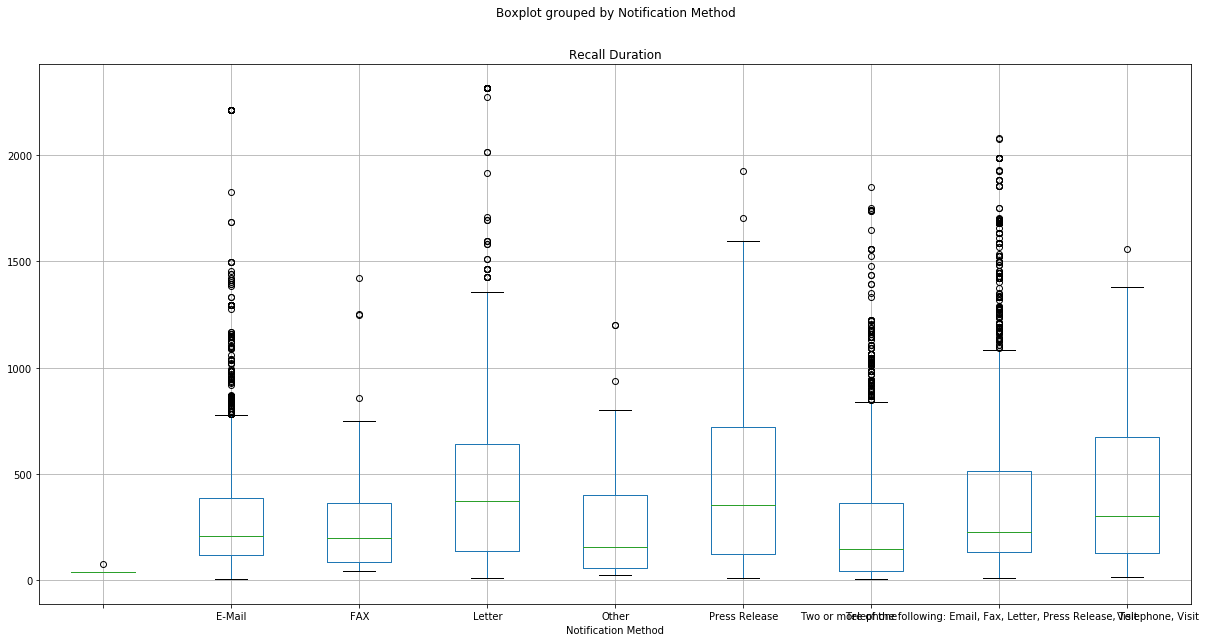

In [6]:
clean_df.boxplot("Recall Duration", by = "Notification Method", figsize = (20,10))

In [7]:
mean = clean_df.groupby('Class')['Recall Duration'].median().reset_index()
mean.head()

,Class,Recall Duration
0,Class I,245.0
1,Class II,247.0
2,Class III,239.0
3,Not Yet Classified,97.0


In [8]:
# Create an array that contains the number of users each language has
users = [245, 247, 239, 97]
x_axis = np.arange(len(users))

In [9]:
%matplotlib notebook

<IPython.core.display.Javascript object>


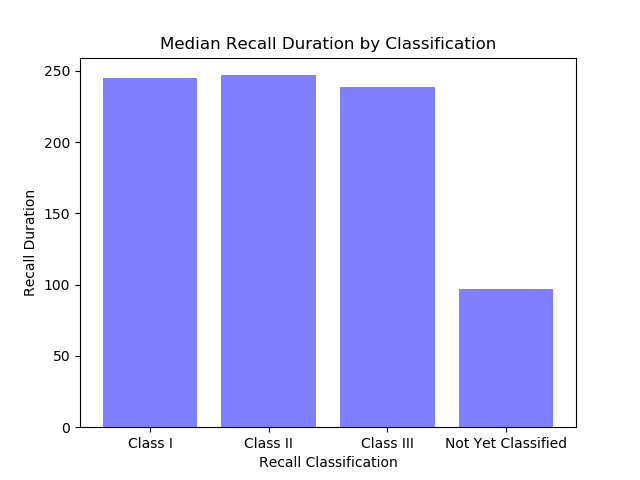

<BarContainer object of 4 artists>

In [26]:
# Tell matplotlib that we will be making a bar chart
# Users is our y axis and x_axis is, of course, our x axis
# We apply align="edge" to ensure our bars line up with our tick marks
plt.bar(x_axis, users, color='b', alpha=0.5, align="center")

In [28]:
# Tell matplotlib where we would like to place each of our x axis headers
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ["Class I", "Class II", "Class III", "Not Yet Classified"])

([<matplotlib.axis.XTick at 0x183131be548>,
 <a list of 4 Text xticklabel objects>)

In [27]:
# Give our chart some labels and a tile
plt.title("Median Recall Duration by Classification")
plt.xlabel("Recall Classification")
plt.ylabel("Recall Duration")

Text(38.222222222222214, 0.5, 'Recall Duration')

In [13]:
# Performing a GET Request and saving the 
# API's response within a variable

with open('food.json') as json_file:
    data = json.load(json_file)


#Importing to dataframe

TotalRecall = pd.DataFrame(data['results'])

group = TotalRecall.groupby(['classification'])

count = group.count()

In [14]:
count.head()


,center_classification_date,report_date,postal_code,termination_date,recall_initiation_date,recall_number,city,more_code_info,event_id,distribution_pattern,...,reason_for_recall,initial_firm_notification,status,product_type,country,product_description,code_info,address_1,address_2,product_quantity
classification,,,,,,,,,,,,,,,,,,,,,
Class I,8022,8026,8026,7496,8026,8026,8026,1,8026,8026,...,8026,8026,8026,8026,8026,8026,8026,8026,8026,8026
Class II,9768,9768,9768,8869,9768,9768,9768,0,9768,9768,...,9768,9768,9768,9768,9768,9768,9768,9768,9768,9768
Class III,1063,1063,1063,1011,1063,1063,1063,0,1063,1063,...,1063,1063,1063,1063,1063,1063,1063,1063,1063,1063
Not Yet Classified,0,58,58,5,58,58,58,0,58,58,...,58,58,58,58,58,58,58,58,58,58


    Chi Square Analysis

In [29]:
# Observed data in a (hypothetical) survey of 300 people 
observed = pd.Series([8026,9768,1063], index=["Class I", "Class II", "Class III"])

In [30]:
# Create a data frame
df = pd.DataFrame([observed]).T

In [31]:
# Add a column whose default values are the expected values
df[1] = 5000

In [32]:
# Rename columns
df.columns = ["Observed", "Expected"]

In [33]:
# View the data frame
df

,Observed,Expected
Class I,8026,5000
Class II,9768,5000
Class III,1063,5000


In [34]:
# The degree of freedom is 3-1 = 2
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.
critical_value = stats.chi2.ppf(q = 0.95, df = 2)

In [35]:
# The critical value
critical_value

5.991464547107979

In [36]:
# Run the chi square test with stats.chisquare()
stats.chisquare(df['Observed'], df['Expected'])

Power_divergenceResult(statistic=9478.0938, pvalue=0.0)

Conclusion
Since the chi square value of 9478.09 exceeds the critical value of 5.99, we conclude that the results are statistically significant.

In [23]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [24]:
import geocoder

In [25]:
post_df['Latitude'], post_df['Longitude'] = zip(*post_df['Postcode'].apply(get_geocoder))

NameError: name 'post_df' is not defined

Pie Chart

In [37]:
%matplotlib notebook

In [38]:
# Labels for the sections of our pie chart
labels = ["Class I", "Class II", "Class III", "Not Yet Classified"]

# The values of each section of the pie chart
sizes = [8026, 9768, 1063, 58]

# The colors of each section of the pie chart
colors = ["red", "orange", "lightcoral", "lightskyblue"]

# Tells matplotlib to seperate the "Python" section from the others
explode = (0.1, 0, 0, 0)

<IPython.core.display.Javascript object>


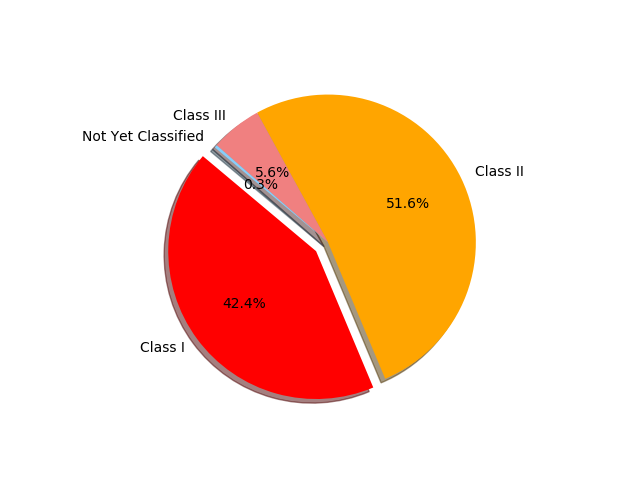

([<matplotlib.patches.Wedge at 0x183130b4408>,
 [Text(-0.9661523872801787, -0.7117229549149107, 'Class I'),
  Text(0.9911034987319822, 0.4771937287949454, 'Class II'),
  Text(-0.6889698714735111, 0.8575083184446515, 'Class III'),
  Text(-0.8357985500811371, 0.7151508817601144, 'Not Yet Classified')],
 [Text(-0.5635888925801041, -0.4151717237003645, '42.4%'),
  Text(0.5406019083992629, 0.26028748843360655, '51.6%'),
  Text(-0.37580174807646055, 0.46773181006071896, '5.6%'),
  Text(-0.4558901182260747, 0.39008229914188053, '0.3%')])

In [39]:
# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)

In [ ]:
# Tells matplotlib that we want a pie chart with equal axes
plt.axis("equal")